<a href="https://colab.research.google.com/github/dodofk/IM-Camp-ML-Course/blob/main/Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs Dog Classification

### Download Dataset

In [92]:
# !cp drive/MyDrive/MIULAB_DATASET/dogs_vs_cats/train.zip train.zip
# !cp drive/MyDrive/MIULAB_DATASET/dogs_vs_cats/test1.zip test1.zip
# !unzip train.zip
# !unzip test1.zip

### Install Package

In [93]:
!pip install tqdm wandb --upgrade --quiet

### Import Needed Package

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision
from torchvision import transforms

from tqdm.autonotebook import tqdm

import wandb

### Setup Wandb

In [7]:
# !wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 41
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [57]:
# wandb.init("cats_vs_dogs")

### Setup Dataset and utils function

In [6]:
class MyDataset(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transforms = transforms
        self.files = os.listdir(path)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.path+self.files[idx])

        input = self.transform(image)


        if "train" in self.path:
           label = 1 if "dog" in self.files[idx] else 0
           return input, label

        return input, self.files[idx]

    def __len__(self):
        return len(self.files)

process = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
def build_loaders():
    train_dataset = MyDataset("train/", process)
    test_dataset = MyDataset("test1/", process)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    return train_dataloader, test_dataloader

### Some Demonstration of Dataset

In [33]:
cat = Image.open("train/cat.0.jpg").convert()

dog = Image.open("train/dog.1.jpg").convert()

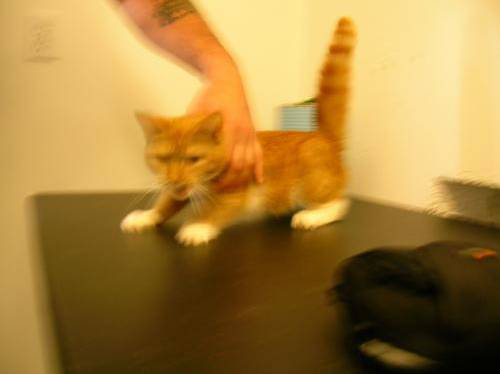

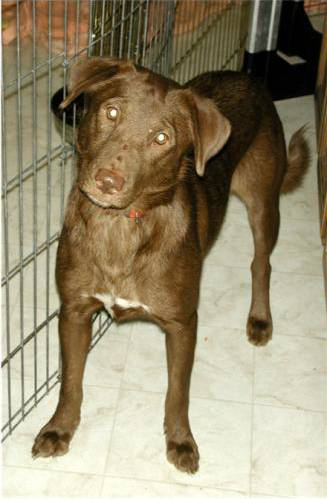

In [34]:
display(cat, dog)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


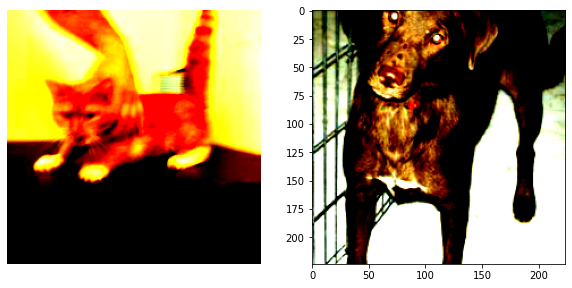

In [35]:
from matplotlib import pyplot as plt

cat_pre = process(Image.open("train/cat.0.jpg"))

dog_pre = process(Image.open("train/dog.1.jpg"))


_, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(cat_pre.permute(1, 2, 0))
axes[0].axis("off")
axes[1].imshow(dog_pre.permute(1, 2, 0))
axes[0].axis("off")

plt.show()

### Setup Model

In [8]:
class ResNetModify(nn.Module):
    def __init__(
        self,
        model_name: str = "resnet34",
        pretrained: bool=True,
        output_dim: int = 2,
    ):
        super().__init__()
        assert model_name in ['resnet34'], "Invalid model"
        if model_name == "resnet34":
            self.model = torchvision.models.resnet34(pretrained=pretrained)
            self.model.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.model(x)
        return x

### Train

In [13]:
class cfg:
    lr = 1e-4
    weight_decay = 1e-4
    n_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 64

In [60]:
def train_epoch(model, train_loader, optimizer) -> None:
    tqdm_object = tqdm(train_loader, total=len(train_loader))

    cur_loss = 0
    cur_count = 0
    train_total = 0
    train_acc = 0
    
    for image, label in tqdm_object:
        optimizer.zero_grad()

        image, label = image.to(cfg.device), label.to(cfg.device)

        label = F.one_hot(label.to(torch.int64)) 
        pred = model(image)

        pred_label = torch.argmax(pred, dim=1)

        loss_fn = nn.BCEWithLogitsLoss()
        
        loss = loss_fn(pred, label.to(torch.float32))
        loss.backward()

        optimizer.step()

        train_total += cfg.batch_size
        train_acc += (pred_label.to("cpu") == torch.argmax(label, dim=1).to("cpu")).sum().item()


        wandb.log({"train_loss": loss.item(), "train_acc": train_acc/train_total})

        cur_count += 1
        cur_loss += loss.item()

        tqdm_object.set_postfix(train_loss=cur_loss/cur_count, train_acc=train_acc/train_total)

In [61]:
train_dataloader, test_dataloader = build_loaders()

model = ResNetModify().to(cfg.device)

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay,
)


best_loss = float("inf")

model.train()

for epoch in range(cfg.n_epochs):
    print(f"Epoch: {epoch+1}")
    train_epoch(
        model=model,
        train_loader=train_dataloader,
        optimizer=optimizer,
    )

torch.save(model.state_dict(), "drive/MyDrive/MIULAB_DATASET/dogs_vs_cats/finetune_best.pt")

Epoch: 1


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

In [71]:
dog_pre_ = dog_pre.unsqueeze(0).to(cfg.device)
model(dog_pre_) 

tensor([[-0.3611,  0.3696]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Predection

In [10]:
model = ResNetModify(pretrained=False)
model.load_state_dict(torch.load("drive/MyDrive/MIULAB_DATASET/dogs_vs_cats/finetune_best.pt"))

<All keys matched successfully>

In [56]:
model.eval()
model.to(cfg.device)
_, pred_loader = build_loaders()

tqdm_object = tqdm(pred_loader, total=len(pred_loader))

cur_loss = 0
cur_count = 0

files = np.array([])
preds = np.array([])


for image, file in tqdm_object:

    image = image.to(cfg.device)

    pred = model(image)

    pred_label = torch.argmax(pred, dim=1)


    for file_ in file:
        files = np.append(files, int(file_.replace('.jpg', '')) )

    for pred_ in pred_label:
        preds = np.append(preds, pred_.detach().to("cpu").numpy())

  0%|          | 0/196 [00:00<?, ?it/s]

In [95]:
pred_df = pd.read_csv("drive/MyDrive/MIULAB_DATASET/dogs_vs_cats/result.csv")

In [66]:
# for index, file in enumerate(pred_df['id']):
#     file_index = np.argwhere(files==file)
#     pred_df['label'][index] = preds[file_index]

In [96]:
def demo(id):
    unknown = Image.open(f"test1/{id}.jpg").convert()
    display(unknown)
    result = pred_df['label'][id-1]
    if result:
        print("dog")
    else:
        print("cat")

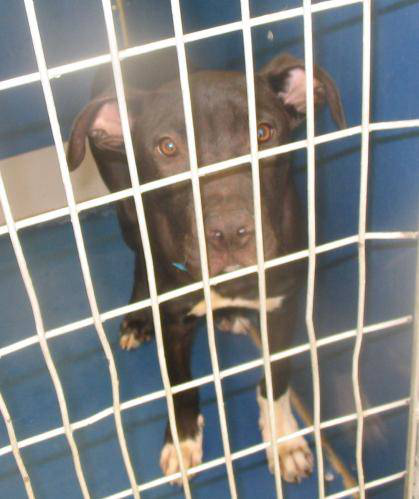

dog


In [97]:
# 144(no head cat), 944(dog behind object)
demo(944)